# Assignment #1: Write up a report on U.N. World Happiness Data

# GitHub Link: https://github.com/Bobbie8881/Projects-in-ML

Get data in and set up X_train, X_test, y_train objects

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#Get competition data from course folder and unzip
# importing the zipfile module
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("world_happiness_competition_data.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall()

In [6]:
# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

X_train.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Peru,0.960,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.000000
1,Nicaragua,0.694,1.325,0.835,0.435,0.200,0.127,Nicaragua,Americas,Latin America and the Caribbean,125.611111
2,Greece,1.181,1.156,0.999,0.067,0.000,0.034,Greece,Europe,Southern Europe,112.000000
3,Qatar,1.684,1.313,0.871,0.555,0.220,0.167,Qatar,Asia,Western Asia,57.333333
4,Uzbekistan,0.745,1.529,0.756,0.631,0.322,0.240,Uzbekistan,Asia,Central Asia,125.611111


In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit your preprocessor object
preprocess=preprocessor.fit(X_train)

In [11]:
# Write function to transform data with preprocessor

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

# Explore bivariate results (Use visualizations!)

## Describe any relationships you see between particular features and the target variable


In [21]:
# Get only numeric features
numeric_feature = numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)

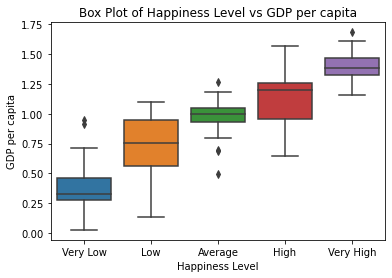

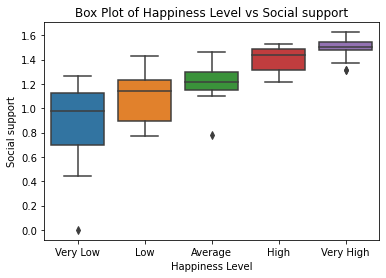

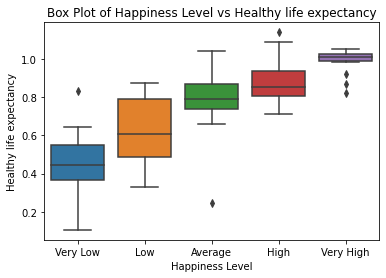

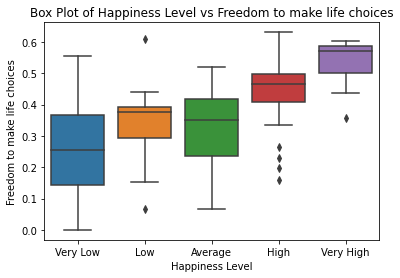

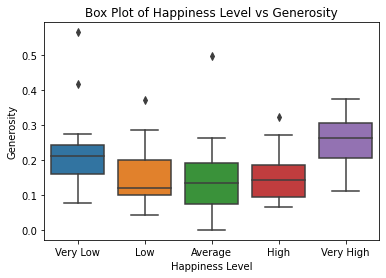

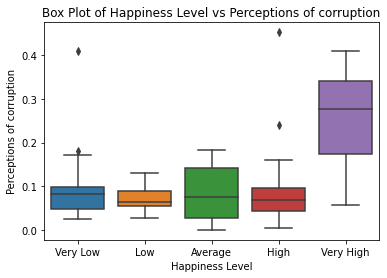

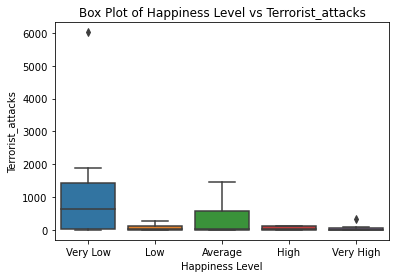

In [43]:
# Make box plots to see relationships between numeric features and the target variable
for x in numeric_feature:
    sns.boxplot(x = y_train_labels, y = X_train[x], order = ['Very Low', 'Low', 'Average', 'High', 'Very High'])
    plt.title("Box Plot of Happiness Level vs " + str(x))
    plt.xlabel("Happiness Level")
    plt.show()

### As we can see from the above box plots, countries or regions with higher median in GDP per capita, social support, healthy life expectancy, freedom to make life choices tend to have higher happiness level. Features like generosity and perceptions of corruption do not matter much only if the median happiness level is very high. Countries and regions that have the higheset terrorist attacks tend to have lower median happiness level.

## Examine features that predict happiness categories using one or more models that allow for automatic feature selection 

## Explain any meaningful findings

In [102]:
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['GDP per capita', 'Social support',
                                  'Healthy life expectancy',
                                  'Freedom to make life choices', 'Generosity',
                                  'Perceptions of corruption',
                                  'Terrorist_attacks']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['region', 'sub-region'

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel


lr = LogisticRegression()
lr.fit(preprocessor(X_train), y_train_labels)
model = SelectFromModel(lr, prefit=True)
print(model.get_support())
print(sum(model.get_support()))
select_x = model.transform(preprocessor(X_train))

[ True  True  True  True  True  True  True False False  True False False
 False  True False False False False False False  True  True False False
 False False]
11


### Applying automatic feature selection to the logistic regression model, I found out that all of the original numerical features were selected and only four of one-hot encdoing categorical features were selected.

## Experiment with different prediction models to try to predict World Happiness well (Fit and compare, at minimum, three models)


## Model 1: Random Forest with GridSearchCV

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_estimators': np.arange(100, 1000, 100),'max_depth':[1, 3, 5, 7, 9]} #np.arange creates sequence of numbers for each k value

gridmodel = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10)

#use meta model methods to fit score and predict model:
gridmodel.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(gridmodel.best_score_))
print("best parameters: {}".format(gridmodel.best_params_))

best mean cross-validation score: 0.704
best parameters: {'max_depth': 7, 'n_estimators': 500}


## Model 2: GradientBoostingClassifier

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {'n_estimators': np.arange(100, 500, 100),'max_depth':[1, 3, 5, 7, 9]}

#Code to fit model:
model = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=10)

#use meta model methods to fit score and predict model:
model.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(model.best_score_))
print("best parameters: {}".format(model.best_params_))

model.score(preprocessor(X_train), y_train_labels)

best mean cross-validation score: 0.626
best parameters: {'max_depth': 1, 'n_estimators': 100}


0.9772727272727273

# Model 3: KNeighborsClassifier with GridSearchCV

In [129]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1, 20, 2)} #np.arange creates sequence of numbers for each k value

model3 = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10)

#use meta model methods to fit score and predict model:
model3.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(model3.best_score_))
print("best parameters: {}".format(model3.best_params_))

best mean cross-validation score: 0.650
best parameters: {'n_neighbors': 13}


## Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.